In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchtext
from torchtext.data import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import Tensor
from typing import Tuple
from torch.nn import functional as F
import math

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NMT/final_data.csv')

In [ ]:
# tokenize by space
tokenizer = get_tokenizer(tokenizer=None)

In [ ]:
def build_vocab(iter_text_data, tokenizer):
    counter = Counter()
    for line in iter_text_data:#df.text_clean.to_numpy():
        counter.update(tokenizer(line))
    return Vocab(counter, min_freq=1000, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [ ]:
%%time
tone_vocab = build_vocab(df.text_clean.to_numpy(), tokenizer)
no_tone_vocab = build_vocab(df.text_clean_no_accent.to_numpy(), tokenizer)

CPU times: user 1min 16s, sys: 328 ms, total: 1min 17s
Wall time: 1min 17s


In [ ]:
BATCH_SIZE = 64
PAD_IDX = tone_vocab['<pad>']
BOS_IDX = tone_vocab['<bos>']
EOS_IDX = tone_vocab['<eos>']

In [ ]:
len(tone_vocab), len(no_tone_vocab)

(4136, 2248)

In [ ]:
def data_process(tone_array, no_tone_array, tone_vocab, no_tone_vocab, tokenizer):
    data = []
    for (tone_str, no_tone_str) in tqdm(zip(tone_array, no_tone_array)):
#         print(tone_str, no_tone_str)
#         break
        tone_tensor_ = torch.tensor([tone_vocab[token] for token in tokenizer(tone_str)],
                                dtype=torch.long)
        no_tone_tensor_ = torch.tensor([no_tone_vocab[token] for token in tokenizer(no_tone_str)],
                                dtype=torch.long)
        data.append((tone_tensor_, no_tone_tensor_))
    return data

In [ ]:
train_range = 100000#int(df.shape[0]*1/100)
test_range = 1000#int(df.shape[0]*0.5/100)
df_train = df.iloc[:train_range, :]
df_test = df.iloc[-test_range:, :]
df_train.shape, df_test.shape

((100000, 2), (1000, 2))

In [ ]:
df_train

,text_clean,text_clean_no_accent
0,chây ì nộp phạt nguội,chay i nop phat nguoi
1,cháu đòi tiền cơm dì đòi tiền nhà,chau doi tien com di doi tien nha
2,đà nẵng nghiên cứu tiện ích nhắn tin khi vi ph...,da nang nghien cuu tien ich nhan tin khi vi ph...
3,khó xử vụ mẹ tuổi trộm xe hơi của con gái,kho xu vu me tuoi trom xe hoi cua con gai
4,thay đổi về đăng ký chuyển nhượng xe từ bạn cầ...,thay doi ve dang ky chuyen nhuong xe tu ban ca...
...,...,...
99995,mùi hương nổi bật năm,mui huong noi bat nam
99996,im lặng cho hoa nở nghi thức để đến vẻ đẹp,im lang cho hoa no nghi thuc de den ve dep
99997,những khoảnh khắc lịch sử của u việt nam tại c...,nhung khoanh khac lich su cua u viet nam tai c...
99998,hành động đẹp của duy mạnh làm tan chảy trái t...,hanh dong dep cua duy manh lam tan chay trai t...


In [ ]:
df_test.head(5)

,text_clean,text_clean_no_accent
9478271,quan hệ quốc phòng mỹ ấn độ thắt chặt sau thỏa...,quan he quoc phong my an do that chat sau thoa...
9478272,xin lãnh đạo nhịn phát biểu khai giảng,xin lanh dao nhin phat bieu khai giang
9478273,bđbp tỉnh quảng nam nhận trách nhiệm trong vụ ...,bdbp tinh quang nam nhan trach nhiem trong vu ...
9478274,premier league hù dọa châu âu bằng tỷ bảng,premier league hu doa chau au bang ty bang
9478275,năm thực hiện tái cơ cấu nông nghiệp mờ nhạt b...,nam thuc hien tai co cau nong nghiep mo nhat b...


In [ ]:
# %%time
train_data = data_process(df_train.text_clean.to_numpy(), 
                          df_train.text_clean_no_accent.to_numpy(), 
                          tone_vocab, no_tone_vocab, tokenizer)
# val_data = data_process(df_test.text_clean.to_numpy(), 
#                           df_test.text_clean_no_accent.to_numpy(), 
#                           tone_vocab, no_tone_vocab, tokenizer)

100000it [00:03, 27554.93it/s]


In [ ]:
val_data = data_process(df_test.text_clean.to_numpy(), 
                          df_test.text_clean_no_accent.to_numpy(), 
                          tone_vocab, no_tone_vocab, tokenizer)

1000it [00:00, 53404.77it/s]


In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    tone_batch, no_tone_batch = [], []
    for (tone_item, no_tone_item) in data_batch:
        # Remove bos token
        tone_batch.append(torch.cat([tone_item, torch.tensor([EOS_IDX])]))
        no_tone_batch.append(torch.cat([no_tone_item, torch.tensor([EOS_IDX])]))
        
    tone_batch = pad_sequence(tone_batch, padding_value=PAD_IDX, batch_first=True)
    no_tone_batch = pad_sequence(no_tone_batch, padding_value=PAD_IDX, batch_first=True)
    return no_tone_batch, tone_batch

In [ ]:
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

In [ ]:
%%time
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)


CPU times: user 123 µs, sys: 0 ns, total: 123 µs
Wall time: 129 µs


In [ ]:
for X, y in train_iter:
    print(X[0])
    print(X.shape)
    break

tensor([ 98, 134,  33, 117, 547, 297,  14, 170,  65,  20,  22,   7,  56, 151,
          3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
torch.Size([64, 25])


# Model

In [ ]:
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  # queries:  (batch_size*num_head x num_steps x num_hiddens/num_head) 
  # keys:     (batch_size*num_head x num_steps x num_hiddens/num_head) 
  # values:   (batch_size*num_head x num_steps x num_hiddens/num_head) 
  # mask:     (batch_size*num_heads x 1 x num_steps)
  def forward(self, queries, keys, values, mask):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)

    # scores: (batch_size*num_head x num_steps x num_steps)
    # mask:   (batch_size*num_heads x 1 x num_steps)
    # self.attention_weights: (batch_size*num_head x num_steps x num_steps)
    self.attention_weights = F.softmax(scores.masked_fill(mask=mask, value=-np.inf), dim=-1)

    # output: (batch_size*num_head x num_steps x num_hiddens/num_head)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
# How mask work
scores = torch.ones(2, 2, 10)
mask = (torch.rand(2, 2, 10) > 0.5)
scores.masked_fill(mask=mask, value=-np.inf),  mask

(tensor([[[-inf, 1., -inf, -inf, -inf, 1., -inf, 1., -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, 1., -inf, 1., -inf]],
 
         [[-inf, 1., -inf, -inf, -inf, 1., 1., 1., -inf, -inf],
          [-inf, -inf, 1., -inf, 1., 1., -inf, 1., 1., 1.]]]),
 tensor([[[ True, False,  True,  True,  True, False,  True, False,  True,  True],
          [ True,  True,  True,  True,  True,  True, False,  True, False,  True]],
 
         [[ True, False,  True,  True,  True, False, False, False,  True,  True],
          [ True,  True, False,  True, False, False,  True, False, False, False]]]))

In [ ]:
# with DotProductAttention, both the query and the key have the same vector length
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones(2, 10, 2)
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)

attention = DotProductAttention(0.1)
attention.eval()
mask = torch.stack([torch.cat((torch.zeros(2), torch.ones(8))),
                    torch.cat((torch.zeros(6), torch.ones(4)))]).unsqueeze(1).type(torch.bool)
attention(queries, keys, values, mask).shape, values.shape

(torch.Size([2, 1, 4]), torch.Size([2, 10, 4]))

In [ ]:
def transpose_qkv(X, num_heads):
  # X: batch_size x key-value pairs x num_hiddens

  # X shape -> batch_size x key-value pairs x num_head x num_hiddens/num_head
  X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
  X = X.permute(0, 2, 1, 3)

  return X.reshape(-1, X.shape[2], X.shape[3])
def transpose_output(X, num_heads):
  X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])

  X = X.permute(0, 2, 1, 3)

  return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self, 
               key_size, query_size, value_size, 
               num_hiddens, num_heads, dropout, 
               bias=False):
    super().__init__()
    self.num_heads = num_heads
    # self.attention = AdditiveAttention(int(key_size/num_heads), int(query_size/num_heads), int(num_hiddens/num_heads), dropout)
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_v = nn.Linear(value_size, num_hiddens, bias=False)
    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=False)
  
  # queries: (batch_size x num_steps x num_hiddens) 
  # keys: (batch_size x num_steps x num_hiddens) 
  # values: (batch_size x num_steps x num_hiddens) 
  # mask: (batch_size*num_heads x num_steps)
  def forward(self, queries, keys, values, mask):
    queries = transpose_qkv(self.W_q(queries), self.num_heads)
    keys = transpose_qkv(self.W_k(keys), self.num_heads)
    values = transpose_qkv(self.W_v(values), self.num_heads)
    
    # after transpose_qkv
    # queries: (batch_size*num_head x num_steps x num_hiddens/num_head) 
    # keys: (batch_size*num_head x num_steps x num_hiddens/num_head) 
    # values: (batch_size*num_head x num_steps x num_hiddens/num_head) 

    output = self.attention(queries, keys, values, mask)
    # output: (batch_size*num_head x num_steps x num_hiddens/num_head)

    output_concat = transpose_output(output, self.num_heads)
    # output_concat: (batch_size x num_steps x num_hiddens)
    # print(output_concat.shape, values.shape)
    # return shape: (batch_size x num_steps x num_hiddens)
    return self.W_o(output_concat)

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiheadAttention(num_hiddens, num_hiddens, num_hiddens, 
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiheadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries, num_kvpairs = 2, 10, 10
mask = torch.stack([torch.cat((torch.zeros(2), torch.ones(8))),
                    torch.cat((torch.zeros(6), torch.ones(4)))]).unsqueeze(1).type(torch.bool).repeat_interleave(5, dim=0)
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, mask).shape
# mask.shape

torch.Size([2, 10, 100])

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, num_hiddens, dropout, max_len=1000):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

    self.P = torch.zeros((1, max_len, num_hiddens))

    X = torch.arange(max_len, dtype=torch.float32).reshape(
        -1, 1)/torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X)
    self.P[:, :, 1::2] = torch.cos(X)
  
  # X: (batch_size x num_steps x num_hiddens)
  def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    # return shape: (batch_size x num_steps x num_hiddens)
    return self.dropout(X)

In [ ]:
class PositionWiseFFN(nn.Module):
  def __init__(self, ffn_num_inputs, ffn_num_hiddens, ffn_num_outputs):
    super().__init__()
    self.dense1 = nn.Linear(ffn_num_inputs, ffn_num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
  # X: (batch_size x num_steps x num_hiddens)
  def forward(self, X):
    # FFN is the same for every num_steps
    # num_hiddens should be equal to ffn_num_inputs, ffn_num_outputs
    # self.dense1(X): (batch_size x num_steps x ffn_num_hiddens)
    # return shape:   (batch_size x num_steps x ffn_num_outputs)
    return self.dense2(self.relu(self.dense1(X)))

In [ ]:
class AddNorm(nn.Module):
  def __init__(self, normalized_shape, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(normalized_shape)
  # X: (batch_size x num_steps x num_hiddens)
  # Y: (batch_size x num_steps x num_hiddens)
  def forward(self, X, Y):
    # return shape: (batch_size x num_steps x num_hiddens)
    return self.ln(self.dropout(Y) + X)

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False):
    super().__init__()
    self.attention = MultiheadAttention(key_size, query_size, value_size, 
                                        num_hiddens, num_heads, dropout)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(norm_shape, dropout)
  # X: (batch_size x num_steps x num_hiddens) 
  # mask: (batch_size*num_heads x num_steps)
  def forward(self, X, mask):
    # self.attention(X, X, X, mask): (batch_size x num_steps x num_hiddens)
    Y = self.addnorm1(X, self.attention(X, X, X, mask))
    # Y: (batch_size x num_steps x num_hiddens)

    # self.ffn(Y):  (batch_size x num_steps x num_hiddens)
    # return shape: (batch_size x num_steps x num_hiddens)
    return self.addnorm2(Y, self.ffn(Y))

In [ ]:
X = torch.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
mask = torch.stack([torch.cat((torch.zeros(3), torch.ones(97))),
                    torch.cat((torch.zeros(2), torch.ones(98)))]).unsqueeze(1).type(torch.bool).repeat_interleave(8, dim=0)
encoder_blk(X, mask).shape

torch.Size([2, 100, 24])

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.num_heads = num_heads
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()

    for i in range(num_layers):
      self.blks.add_module(
          "block " + str(i),
          EncoderBlock(key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias))
  # X: (batch_size x num_steps)
  # mask: (batch_size*num_heads x 1 x  num_steps)
  def forward(self, X, mask):
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    # X: (batch_size x num_steps x num_hiddens)

    self.attention_weights = [None]*len(self.blks)

    for i, blk in enumerate(self.blks):
      # X: (batch_size x num_steps x num_hiddens)
      X = blk(X, mask)
      self.attention_weights[i] = blk.attention.attention.attention_weights

    # return shape: (batch_size x num_steps x num_hiddens)
    return X

In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
mask = torch.stack([torch.cat((torch.zeros(3), torch.ones(97))),
                    torch.cat((torch.zeros(2), torch.ones(98)))]).unsqueeze(1).type(torch.bool).repeat_interleave(8, dim=0)
encoder(torch.ones((2, 100), dtype=torch.long), mask).shape

torch.Size([2, 100, 24])

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i):
    super().__init__()
    self.i = i
    self.num_heads = num_heads
    self.attention1 = MultiheadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    # self.attention1 = DotProductAttention(dropout)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.attention2 = MultiheadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    self.addnorm2 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm3 = AddNorm(norm_shape, dropout)


  # X:                 (batch_size x num_steps, num_hiddens)
  # state: [(batch_size x num_steps x num_hiddens), (batch_size*num_heads x num_steps), [None]*self.num_layers]
  def forward(self, X, state):
    enc_outputs, enc_mask = state[0], state[1]
    # enc_outputs: (batch_size x num_steps x num_hiddens)
    # enc_mask:    (batch_size*num_heads x num_steps)

    if state[2][self.i] is None:
      key_values = X
      # key_values: (batch_size x num_steps x num_hiddens)
    else:
      key_values = torch.cat([state[2][self.i], X], axis = 1)
      # never run in here?
      # print("layer", self.i, "key_values.shape", key_values.shape)
    state[2][self.i] = key_values

    batch_size, num_steps, _ = X.shape
    if self.training:
      # spectial mask for each time step
      dec_mask = torch.ones(batch_size, num_steps, num_steps).triu(diagonal=1).type(torch.bool).repeat(self.num_heads, 1, 1).to(device)
      # dec_mask = torch.zeros(batch_size, num_steps).type(torch.bool).unsqueeze(1)#.repeat(self.num_heads, 1, 1).to(device)
      # dec_mask: (batch_size*num_heads, 1, num_steps)
    else:
      dec_mask = torch.zeros(batch_size, num_steps, num_steps).type(torch.bool).repeat(self.num_heads, 1, 1).to(device)
      # dec_mask: (batch_size*num_heads, 1, num_steps)
    
    # self attention?
    X2 = self.attention1(X, key_values, key_values, dec_mask)
    # X2: (batch_size x num_steps x num_hiddens)
    
    Y = self.addnorm1(X, X2)
    # Y: (batch_size x num_steps x num_hiddens)

    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_mask)
    # Y2: (batch_size x num_steps x num_hiddens)
    Z = self.addnorm2(Y, Y2)
    # Z: (batch_size x num_steps x num_hiddens)

    output = self.addnorm3(Z, self.ffn(Z))
    # output: (batch_size x num_steps x num_hiddens)
    # state[2][self.i] is updated
    return output, state

In [ ]:
# How decoder mask work
mask = torch.ones(2, 5, 5).triu(diagonal=1).type(torch.bool).repeat(2, 1, 1).to(device)
a = torch.rand((4, 5, 5))
F.softmax(a.masked_fill(mask=mask, value=-np.inf), dim=-1),  mask

(tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5613, 0.4387, 0.0000, 0.0000, 0.0000],
          [0.3536, 0.3291, 0.3173, 0.0000, 0.0000],
          [0.3614, 0.3127, 0.1595, 0.1663, 0.0000],
          [0.1973, 0.1921, 0.2102, 0.2381, 0.1623]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5129, 0.4871, 0.0000, 0.0000, 0.0000],
          [0.2963, 0.4471, 0.2566, 0.0000, 0.0000],
          [0.2521, 0.2197, 0.3099, 0.2182, 0.0000],
          [0.2073, 0.1821, 0.1760, 0.2480, 0.1866]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.6456, 0.3544, 0.0000, 0.0000, 0.0000],
          [0.3208, 0.3301, 0.3491, 0.0000, 0.0000],
          [0.2718, 0.3260, 0.1964, 0.2058, 0.0000],
          [0.1259, 0.2986, 0.1478, 0.2413, 0.1864]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.6475, 0.3525, 0.0000, 0.0000, 0.0000],
          [0.2071, 0.4735, 0.3194, 0.0000, 0.0000],
          [0.2633, 0.2893, 0.2339, 0.2135, 0.0000],
   

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
mask = torch.stack([torch.cat((torch.zeros(3), torch.ones(97))),
                    torch.cat((torch.zeros(2), torch.ones(98)))]).unsqueeze(2).type(torch.bool).repeat_interleave(8, dim=0)
state = [encoder_blk(X, mask), mask, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [ ]:
class TransformerDecoder(nn.Module):
  def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                 dropout):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module(
          'block' + str(i),
          DecoderBlock(key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i)
      )
      self.dense = nn.Linear(num_hiddens, vocab_size)
  def init_state(self, enc_outputs, mask):
    return [enc_outputs, mask, [None]*self.num_layers]

  # X    : (batch_size x num_steps)
  # state: [(batch_size x num_steps x num_hiddens), (batch_size*num_heads x num_steps), [None]*self.num_layers]
  def forward(self, X, state):
    
    X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
    # self.embedding(X): (batch_size x num_steps, num_hiddens)
    # X:                 (batch_size x num_steps, num_hiddens)
    
    self._attention_weights = [[None] * len(self.blks) for _ in range(2)]

    for i, blk in enumerate(self.blks):
      X, state = blk(X, state)
      # X: (batch_size x num_steps x num_hiddens)
      # [(batch_size x num_steps x num_hiddens), (batch_size*num_heads x num_steps), [(state)]]
      self._attention_weights[0][i] = blk.attention1.attention.attention_weights
      self._attention_weights[1][i] = blk.attention2.attention.attention_weights
    
    # return shape: (batch_size x num_steps x vocab_size), [(state)]
    return self.dense(X), state
  def attention_weights(self):
    return self._attention_weights

In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
mask = torch.stack([torch.cat((torch.zeros(3), torch.ones(97))),
                    torch.cat((torch.zeros(2), torch.ones(98)))]).unsqueeze(2).type(torch.bool).repeat_interleave(8, dim=0)
enc_outputs = encoder(torch.ones((2, 100), dtype=torch.long), mask)

decoder = TransformerDecoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
dec_state = decoder.init_state(enc_outputs, mask)
# dec_X = torch.tensor([[2]*2]).reshape(-1, 1)
decoder(torch.ones((2, 100), dtype=torch.long), dec_state)[0].shape

torch.Size([2, 100, 200])

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 pad_idx: int,
                 device: torch.device,):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
    def create_mask(self, src, num_heads):
      return (src == self.pad_idx).unsqueeze(1).type(torch.bool).repeat_interleave(num_heads, dim=0).to(device)
    # enc_X: (batch_size x num_steps)
    # dec_X: (batch_size x num_steps)
    def forward(self,
                enc_X: Tensor,
                dec_X: Tensor) -> Tensor:
        mask = self.create_mask(enc_X, self.encoder.num_heads).to(self.device)
        # mask: (batch_size*num_heads x 1 x num_steps)

        enc_outputs = self.encoder(enc_X, mask)
        # enc_outputs: (batch_size x num_steps x num_hiddens)

        dec_state = self.decoder.init_state(enc_outputs, mask)
        # dec_state: [enc_outputs, mask, [None]*self.num_layers]
        # [(batch_size x num_steps x num_hiddens), (batch_size*num_heads x num_steps), [None]*self.num_layers]

        # return shape: (batch_size x num_steps x vocab_size)
        return self.decoder(dec_X, dec_state)

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs, no_tone_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    PAD_IDX = tone_vocab.stoi['<pad>']
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    net.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(data_iter, position=0, leave=True):
            optimizer.zero_grad()
            
            X, Y = [x.to(device) for x in batch]
            # X: (batch_size x num_steps)
            # Y: (batch_size x num_steps)
            bos = torch.tensor([tone_vocab.stoi['<bos>']]*Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # teacher forcing
            # dec_input: (batch_size x Y.shape[1] - 1) remove last <eos>
            
            Y_hat, _ = net(X, dec_input)
            # Y_hat: (batch_size x num_steps x vocab_size)
            # Y: (batch_size x num_steps)
            l = loss(Y_hat.permute(0, 2, 1), Y)#nn.functional.one_hot(Y, len(no_tone_vocab)).squeeze())
            
            l.sum().backward()
            
            # clip gradient
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()
            epoch_loss += l.item()
        if ((epoch + 1) % 1 == 0):
            print(f'Epoch {epoch}, Loss {epoch_loss/len(data_iter):.10f}')

In [ ]:
# def evaluate_seq2seq(net, data_iter, device):
#   net.eval()

#   with torch.no_grad():
#     for batch in tqdm(data_iter, position=0, leave=True):
#       X, Y = [x.to(device) for x in batch]

#       dec_X = torch.tensor([tone_vocab.stoi['<bos>']]*Y.shape[0], device=device).reshape(-1, 1)
#       mask = (X == PAD_IDX).unsqueeze(1).type(torch.bool).repeat_interleave(net.encoder.num_heads, dim=0).to(device)
#       enc_outputs = net.encoder(enc_X, mask)
#       dec_state = net.decoder.init_state(enc_outputs, mask)#.repeat((1, beam_size, 1))

#       for i in range(max_length):
#         Y, dec_state = net.decoder(dec_X, dec_state)

#         dec_X = Y.argmax(dim=2)

In [ ]:
def evaluate(net, sentence, no_tone_vocab, tone_vocab, max_length, device, beam_size):
  net.eval()

  src_tokens = [no_tone_vocab.stoi[word] for word in sentence.lower().split(" ")] + [no_tone_vocab.stoi['<eos>']]

  # print(src_tokens)
  # unsqueeze add more axis (add batch axis)
  enc_X = torch.unsqueeze(
      torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0
  )

  # create mask for encoder
  # mask: (batch_size*num_heads x 1 x num_steps)
  mask = (enc_X == PAD_IDX).unsqueeze(1).type(torch.bool).repeat_interleave(net.encoder.num_heads, dim=0).to(device)
  with torch.no_grad():
    enc_outputs = net.encoder(enc_X, mask)
    # enc_outputs: (batch_size x num_steps x num_hiddens)
  
  
  dec_state = net.decoder.init_state(enc_outputs, mask)#.repeat((1, beam_size, 1))
  # dec_state: [enc_outputs, mask, [None]*self.num_layers]
  # [(batch_size x num_steps x num_hiddens), (batch_size*num_heads x num_steps), [None]*self.num_layers]

  dec_state[0] = dec_state[0].repeat((beam_size, 1, 1))
  dec_state[1] = dec_state[1].repeat((beam_size, 1, 1))

  beam = [Beam(beam_size, 1, 2, 3, GNMTGlobalScorer(), 5) for _ in range(1)]

  for i in range(max_length):
    if all((b.done() for b in beam)):
      break
    with torch.no_grad():
      # beam search automatically return <bos> in the first time
      dec_X = torch.stack([b.get_current_state() for b in beam]).t().contiguous().view(1, -1).t().to(device)
      # dec_state = dec_state.squeeze(0)
      # print("dec_X.shape", dec_X.shape, "dec_state.shape", dec_state.shape)    
      Y, dec_state = net.decoder(dec_X, dec_state)
      # print("Y.shape after passed to decoder", Y.shape)
      # (beam_size, vocab_size)
      # Y = Y.squeeze(dim=1)
      # Y = Y.log()

      select_indices_array = []
      for j, b in enumerate(beam):
        # print("Y.shape", Y.shape)
        # print("Y[:, j].shape", Y[:, j].shape)
        b.advance(Y[:, j])
        
      
      # select_indices_array.append(b.get_current_origin() * 1 + j)
      # print("select_indices_array", select_indices_array)
      # select_indices = torch.cat(select_indices_array) \
      #                 .view(1, beam_size) \
      #                 .transpose(0, 1) \
      #                 .contiguous() \
      #                 .view(-1).type(torch.int32).to(device)
      # print("select_indices", select_indices)
      # dec_state = dec_state.index_select(1, select_indices)
  ret = _from_beam(beam)
  return ret


In [ ]:
def inference(x):
  

# Load pre-trained model

In [ ]:
tone_vocab_size = len(tone_vocab)
no_tone_vocab_size = len(no_tone_vocab)

num_hiddens, num_layers, dropout, batch_size, num_steps = 128, 2, 0.0, 128, 10
lr, num_epochs = 0.001, 20
ffn_num_input, ffn_num_hiddens, num_heads = 128, 256, 4
key_size, query_size, value_size = 128, 128, 128
norm_shape = [128]

enc = TransformerEncoder(no_tone_vocab_size, key_size, query_size, value_size,
                          num_hiddens, norm_shape, ffn_num_input,
                          ffn_num_hiddens, num_heads, num_layers, dropout)

dec = TransformerDecoder(tone_vocab_size, key_size, query_size, value_size,
                          num_hiddens, norm_shape, ffn_num_input,
                          ffn_num_hiddens, num_heads, num_layers, dropout)

net = Seq2Seq(enc, dec, tone_vocab.stoi['<pad>'], device).to(device)

net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/transformers_weights.pth", map_location=torch.device('cpu')))
net.eval()

Seq2Seq(
  (encoder): TransformerEncoder(
    (embedding): Embedding(2248, 128)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blks): Sequential(
      (block 0): EncoderBlock(
        (attention): MultiheadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (W_q): Linear(in_features=128, out_features=128, bias=False)
          (W_k): Linear(in_features=128, out_features=128, bias=False)
          (W_v): Linear(in_features=128, out_features=128, bias=False)
          (W_o): Linear(in_features=128, out_features=128, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.0, inplace=False)
          (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=128, out_features=256, bias=True)
          (relu): ReLU()
          (dense2): Linear(in_features

In [ ]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(net):,} trainable parameters')

The model has 2,010,152 trainable parameters


In [ ]:
train_seq2seq(net, train_iter, lr, num_epochs, no_tone_vocab, device)

  0%|          | 5/1563 [00:00<00:35, 44.04it/s]

Epoch 0, Loss 4.5241308659


  0%|          | 5/1563 [00:00<00:37, 41.86it/s]

Epoch 1, Loss 1.8142873072


  0%|          | 5/1563 [00:00<00:37, 41.71it/s]

Epoch 2, Loss 1.2322631132


  0%|          | 5/1563 [00:00<00:34, 45.64it/s]

Epoch 3, Loss 0.9823733826


  0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch 4, Loss 0.8440905663


  0%|          | 5/1563 [00:00<00:37, 41.24it/s]

Epoch 5, Loss 0.7178445387


  0%|          | 5/1563 [00:00<00:34, 44.80it/s]

Epoch 6, Loss 0.6424244722


  0%|          | 5/1563 [00:00<00:37, 41.39it/s]

Epoch 7, Loss 0.5635342047


  0%|          | 5/1563 [00:00<00:34, 44.72it/s]

Epoch 8, Loss 0.5156823907


  0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch 9, Loss 0.4828316741


  0%|          | 5/1563 [00:00<00:35, 43.33it/s]

Epoch 10, Loss 0.4337879226


  0%|          | 5/1563 [00:00<00:35, 43.86it/s]

Epoch 11, Loss 0.3993516293


  0%|          | 5/1563 [00:00<00:37, 41.81it/s]

Epoch 12, Loss 0.3681752286


  0%|          | 5/1563 [00:00<00:34, 45.25it/s]

Epoch 13, Loss 0.3379901801


  0%|          | 5/1563 [00:00<00:35, 43.44it/s]

Epoch 14, Loss 0.3168007072


  0%|          | 5/1563 [00:00<00:37, 41.14it/s]

Epoch 15, Loss 0.2954433392


  0%|          | 5/1563 [00:00<00:35, 44.16it/s]

Epoch 16, Loss 0.2883934329


  0%|          | 5/1563 [00:00<00:36, 42.70it/s]

Epoch 17, Loss 0.2727549379


  0%|          | 5/1563 [00:00<00:34, 44.71it/s]

Epoch 18, Loss 0.2587469967


100%|██████████| 1563/1563 [00:35<00:00, 44.33it/s]

Epoch 19, Loss 0.2473383568


In [ ]:
# torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/transformers_weights.pth')

# Beam search & Attention visualization

In [ ]:
class GNMTGlobalScorer(object):
    """
    NMT re-ranking score from
    "Google's Neural Machine Translation System" :cite:`wu2016google`
    Args:
       alpha (float): length parameter
       beta (float):  coverage parameter
    """

    def __init__(self):
      super().__init__()

    def score(self, beam, logprobs):
        # """
        # Rescores a prediction based on penalty functions
        # """
        # normalized_probs = self.length_penalty(beam,
        #                                        logprobs,
        #                                        self.alpha)
        # if not beam.stepwise_penalty:
        #     penalty = self.cov_penalty(beam,
        #                                beam.global_state["coverage"],
        #                                self.beta)
        #     normalized_probs -= penalty

        return logprobs

In [ ]:
class Beam(object):
  def __init__(self, size, pad, bos, eos, global_scorer, min_length):
    super().__init__()
    self.prev_ks = []
    self.scores = torch.FloatTensor(size).zero_()
    self.all_scores = []

    self.min_length = min_length

    self.next_ys = [torch.LongTensor(size)
                        .fill_(pad)]
    self.next_ys[0][0] = bos

    self.finished = []

    self.global_scorer = global_scorer

    self._eos = eos
    self.eos_top = False

    self.size = size

  def get_current_state(self):
    "Get the outputs for the current timestep."
    return self.next_ys[-1]

  def get_current_origin(self):
    "Get the backpointers for the current timestep."
    return self.prev_ks[-1]
  def done(self):
    return self.eos_top
  def sort_finished(self, minimum=None):
    if minimum is not None:
        i = 0
        # Add from beam until we have minimum outputs.
        while len(self.finished) < minimum:
            global_scores = self.global_scorer.score(self, self.scores)
            s = global_scores[i]
            self.finished.append((s, len(self.next_ys) - 1, i))
            i += 1

    self.finished.sort(key=lambda a: -a[0])
    scores = [sc for sc, _, _ in self.finished]
    ks = [(t, k) for _, t, k in self.finished]
    return scores, ks

  def get_hyp(self, timestep, k):
      """
      Walk back to construct the full hypothesis.
      """
      hyp = []
      for j in range(len(self.prev_ks[:timestep]) - 1, -1, -1):
          hyp.append(self.next_ys[j + 1][k])
          k = self.prev_ks[j][k]
      return hyp[::-1]
  def advance(self, word_probs):
    word_probs = word_probs.unsqueeze(0)
    # print("word_probs", word_probs.shape)
    num_words = word_probs.size(2)
    
    # dont let this shit end
    cur_len = len(self.next_ys)
    # print("cur_len", cur_len)
    if cur_len < self.min_length:
        for k in range(len(word_probs)):
            word_probs[0][k][self._eos] = -1e20
            # print("word", self._eos, "has", word_probs[k][self._eos])

    if len(self.prev_ks) > 0:
      beam_scores = word_probs + self.scores.unsqueeze(1).expand_as(word_probs).to(device)
      # print("beam_scores.shape", beam_scores.shape, "word_probs", word_probs.shape, "self.scores.unsqueeze(1).expand_as(word_probs)", self.scores.unsqueeze(1).expand_as(word_probs).shape)
      beam_scores = beam_scores.squeeze(0)
      # print("beam_scores", beam_scores)
      for i in range(self.next_ys[-1].size(0)):
        if self.next_ys[-1][i] == self._eos:
          # print("sentence", i, 'is ended')
          beam_scores[i] = -1e20
    else:
      beam_scores = word_probs[0][0]
      # print("beam_scores.shape first time", beam_scores.shape)

    
    flat_beam_scores = beam_scores.view(-1)
    # print("self.size", self.size, "flat_beam_scores.shape", flat_beam_scores.shape)
    
    best_scores, best_scores_id = flat_beam_scores.topk(self.size, 0,
        True, True)
    
    self.all_scores.append(self.scores)
    self.scores = best_scores
    # print("best_scores", best_scores, "best_scores_id", best_scores_id)
    
    # print("flat_beam_scores", flat_beam_scores, "best_scores", best_scores, "best_scores_id", best_scores_id)
    # print("num_words", num_words)
    prev_k = torch.floor(best_scores_id / num_words).long()
    # print("prev_k", prev_k)
    self.prev_ks.append(prev_k)
    self.next_ys.append((best_scores_id - prev_k * num_words))
    # print("self.prev_ks", self.prev_ks)
    # print("self.next_ys", self.next_ys)
    for i in range(self.next_ys[-1].size(0)):
      if self.next_ys[-1][i] == self._eos:
        # print("self.scores", self.scores)
        global_scores = self.global_scorer.score(self, self.scores)
        s = global_scores[i]
        self.finished.append((s, len(self.next_ys) - 1, i))

    if self.next_ys[-1][0] == self._eos:
      self.all_scores.append(self.scores)
      self.eos_top = True

In [ ]:
def _from_beam(beam):
    ret = {"predictions": [],
            "scores": [],
            "attention": []}
    for b in beam:
        # n_best = self.n_best
        scores, ks = b.sort_finished(minimum=None)
        # print(scores, ks)
        hyps, attn = [], []
        for i, (times, k) in enumerate(ks):#[:n_best]):
            # hyp, att = b.get_hyp(times, k)
            hyp = b.get_hyp(times, k)
            hyps.append(hyp)
            # attn.append(att)
        ret["predictions"].append(hyps)
        ret["scores"].append(scores)
        # ret["attention"].append(attn)
    return ret

In [ ]:
sentence = "Tram nam trong coi nguoi ta"
beam = evaluate(net, sentence, no_tone_vocab, tone_vocab, 20, device, 4)

cur_len 1
word 3 has tensor([ 6.2015, -5.5238, -6.0122,  ..., -0.5067, -1.8321, -6.6582])
beam_scores.shape first time torch.Size([4136])
self.size 4 flat_beam_scores.shape torch.Size([4136])
best_scores tensor([21.5089, 21.0419, 16.5810, 15.8958]) best_scores_id tensor([ 783, 1613, 1234,   22])
num_words 4136
self.prev_ks [tensor([0, 0, 0, 0])]
self.next_ys [tensor([2, 1, 1, 1]), tensor([ 783, 1613, 1234,   22])]
cur_len 2
word 3 has tensor([ 6.4400, -5.5701, -6.0114,  ...,  0.1376, -1.6764, -6.3570])
self.size 4 flat_beam_scores.shape torch.Size([16544])
best_scores tensor([40.8862, 40.0506, 37.3048, 37.2654]) best_scores_id tensor([  22, 1360,   13,   10])
num_words 4136
self.prev_ks [tensor([0, 0, 0, 0]), tensor([0, 0, 0, 0])]
self.next_ys [tensor([2, 1, 1, 1]), tensor([ 783, 1613, 1234,   22]), tensor([  22, 1360,   13,   10])]
cur_len 3
word 3 has tensor([ 6.9119, -5.8007, -6.2600,  ..., -0.1259, -1.6524, -6.1620])
self.size 4 flat_beam_scores.shape torch.Size([16544])
best_score

In [ ]:
# Tram nam trong coi nguoi ta
for prediction in beam['predictions'][0]:
  print(' '.join(tone_vocab.itos[idx] for idx in prediction[:-1]))
  # print(prediction)

trăm năm trong cõi người ta


In [ ]:
# encoder attention: (batch_size*num_head x num_steps x num_steps)
net.encoder.attention_weights[0].shape

torch.Size([4, 6, 6])

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

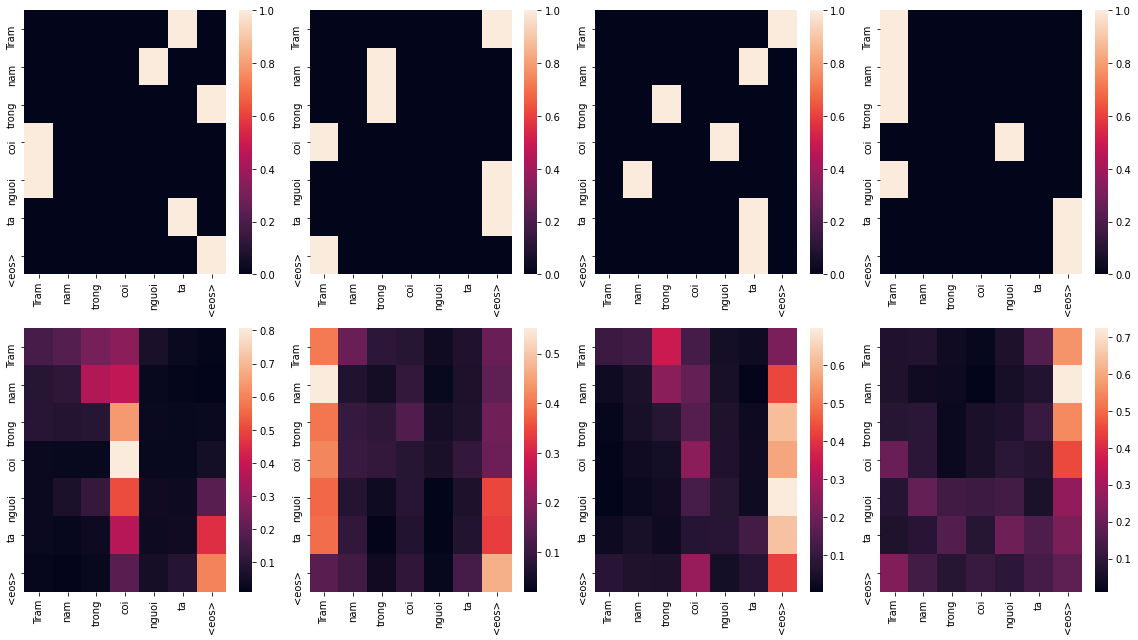

In [ ]:
num_layers = len(net.encoder.attention_weights)
num_heads, num_steps, _ = net.encoder.attention_weights[0].shape
fig, ax = plt.subplots(2, 4, figsize=(16, 9))
for layer in range(num_layers):
  for head in range(num_heads):
    ax[layer, head] = sns.heatmap(net.encoder.attention_weights[layer][head], 
                                  ax=ax[layer, head],
                                  xticklabels=[w for w in sentence.split()] + ["<eos>"],
                                  yticklabels=[w for w in sentence.split()] + ["<eos>"])
plt.tight_layout()

# Evaluate model

In [ ]:
def inference(sentence):
  beam = evaluate(net, sentence, no_tone_vocab, tone_vocab, 20, device, 4)
  if len(beam['predictions'][0]) > 0:
    return ' '.join(tone_vocab.itos[idx] for idx in beam['predictions'][0][0][:-1])
  else:
    return ''

In [ ]:
inference("tram nam roi lai ra di")

'trăm năm rồi lại ra đi'

In [ ]:
%%time
df_test['predict'] = df_test.text_clean_no_accent.apply(inference)

CPU times: user 1min 37s, sys: 1.03 s, total: 1min 38s
Wall time: 49.7 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test

,text_clean,text_clean_no_accent,predict
9478271,quan hệ quốc phòng mỹ ấn độ thắt chặt sau thỏa...,quan he quoc phong my an do that chat sau thoa...,quan hệ quốc phòng mỹ ấn độ thắt chặt sau thỏa...
9478272,xin lãnh đạo nhịn phát biểu khai giảng,xin lanh dao nhin phat bieu khai giang,xin lãnh đạo phật phát biểu khải giang
9478273,bđbp tỉnh quảng nam nhận trách nhiệm trong vụ ...,bdbp tinh quang nam nhan trach nhiem trong vu ...,bđbp tỉnh quảng nam nhận trách nhiệm trong vụ ...
9478274,premier league hù dọa châu âu bằng tỷ bảng,premier league hu doa chau au bang ty bang,premier league <unk> đóa châu âu bằng tỷ bằng
9478275,năm thực hiện tái cơ cấu nông nghiệp mờ nhạt b...,nam thuc hien tai co cau nong nghiep mo nhat b...,năm thực hiện tại cơ cấu nông nghiệp mờ nhất b...
...,...,...,...
9479266,vợ đòi ly hôn vì chồng bạo hành suốt năm,vo doi ly hon vi chong bao hanh suot nam,vợ đòi ly hôn vì chồng bảo hạnh suốt năm
9479267,ppi những e ngại về chất lượng tài sản,ppi nhung e ngai ve chat luong tai san,<unk> những ế <unk> về chất lượng tài sản
9479268,quân đội syria mở rộng vây lấn tấn công trên v...,quan doi syria mo rong vay lan tan cong tren v...,quân đội syria mở rộng vây lần tấn công trên v...
9479269,cháy siêu thị co opmart tiểu thương hoảng loạn...,chay sieu thi co opmart tieu thuong hoang loan...,cháy siêu thị có <unk> tiểu thương hoảng loạn ...


In [ ]:
def sentence_accuracy(row):
  src = row.text_clean.split(" ")
  predict = row.predict.split(" ")
  t = 0
  for i in range(min(len(src), len(predict))):
    if (src[i] == predict[i]):
      t += 1
  return t/len(src)

In [ ]:
%%time
df_test['accuracy'] = df_test.apply(sentence_accuracy, axis=1)

CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 29.8 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test

,text_clean,text_clean_no_accent,predict,accuracy
9478271,quan hệ quốc phòng mỹ ấn độ thắt chặt sau thỏa...,quan he quoc phong my an do that chat sau thoa...,quan hệ quốc phòng mỹ ấn độ thắt chặt sau thỏa...,0.928571
9478272,xin lãnh đạo nhịn phát biểu khai giảng,xin lanh dao nhin phat bieu khai giang,xin lãnh đạo phật phát biểu khải giang,0.625000
9478273,bđbp tỉnh quảng nam nhận trách nhiệm trong vụ ...,bdbp tinh quang nam nhan trach nhiem trong vu ...,bđbp tỉnh quảng nam nhận trách nhiệm trong vụ ...,0.846154
9478274,premier league hù dọa châu âu bằng tỷ bảng,premier league hu doa chau au bang ty bang,premier league <unk> đóa châu âu bằng tỷ bằng,0.666667
9478275,năm thực hiện tái cơ cấu nông nghiệp mờ nhạt b...,nam thuc hien tai co cau nong nghiep mo nhat b...,năm thực hiện tại cơ cấu nông nghiệp mờ nhất b...,0.714286
...,...,...,...,...
9479266,vợ đòi ly hôn vì chồng bạo hành suốt năm,vo doi ly hon vi chong bao hanh suot nam,vợ đòi ly hôn vì chồng bảo hạnh suốt năm,0.800000
9479267,ppi những e ngại về chất lượng tài sản,ppi nhung e ngai ve chat luong tai san,<unk> những ế <unk> về chất lượng tài sản,0.666667
9479268,quân đội syria mở rộng vây lấn tấn công trên v...,quan doi syria mo rong vay lan tan cong tren v...,quân đội syria mở rộng vây lần tấn công trên v...,0.846154
9479269,cháy siêu thị co opmart tiểu thương hoảng loạn...,chay sieu thi co opmart tieu thuong hoang loan...,cháy siêu thị có <unk> tiểu thương hoảng loạn ...,0.818182


In [ ]:
df_test.accuracy.mean()

0.742474838840471

(array([  7.,   2.,   4.,   2.,   6.,  21.,  10.,  16.,  27.,  20.,  72.,
         74.,  49.,  65.,  50.,  86., 134.,  63., 106., 186.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

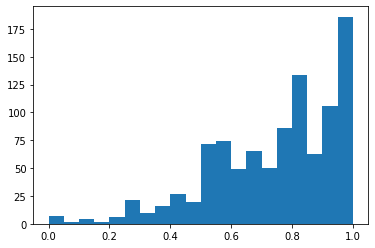

In [ ]:
plt.hist(df_test.accuracy, bins=20)

In [ ]:
df_test[df_test.accuracy < 0.1]

,text_clean,text_clean_no_accent,predict,accuracy
9478409,vào vòng us open venus williams thiết lập kỷ lục,vao vong us open venus williams thiet lap ky luc,<unk> vào hose <unk> <unk> thiết lập kỷ lục me...,0.000000
9478512,nghệ an người dân chưa chịu bàn giao mặt bằng ...,nghe an nguoi dan chua chiu ban giao mat bang ...,,0.000000
9478664,rosol murray càng đánh càng đuối v us open,rosol murray cang danh cang duoi v us open,<unk> <unk> danh căng cảng dưới căng showbiz <...,0.000000
9478777,lấy ý kiến góp ý về dự thảo quy định thực hiện...,lay y kien gop y ve du thao quy dinh thuc hien...,,0.000000
9479016,xã hồng thái huyện an dương tp hải phòng các c...,xa hong thai huyen an duong tp hai phong cac c...,,0.000000
9479020,google sẵn sàng ngưng sử dụng thương hiệu điện...,google san sang ngung su dung thuong hieu dien...,google sản <unk> <unk> <unk> <unk> <unk> hiểu ...,0.090909
9479084,benzema ráo riết tập luyện chờ ngày tái xuất,benzema rao riet tap luyen cho ngay tai xuat,ráo riết ráo riết tập luyện cho ngày tái xuất,0.000000
9479089,vụ mùi hôi tấn công người dân khu nam sài gòn ...,vu mui hoi tan cong nguoi dan khu nam sai gon ...,,0.000000
9479204,miranda kerr lần đầu nói về ảnh khỏa thân của ...,miranda kerr lan dau noi ve anh khoa than cua ...,ecb lần đầu nỗi đau về anh khoa của chồng cũ c...,0.071429
